In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# File and directory operations
import os

# Geospatial data processing and analysis
import geopandas as gpd
import osmnx as ox
import shapely.geometry as sg
import networkx as nx
from scipy.spatial import cKDTree
import folium

# Date and time manipulation
from time import time
from datetime import timedelta

# Images
from IPython.display import display

In [2]:
# Input data
filepath = "C:/Users/ygrin/Documents/Studie - MSc ADS/Utrecht University/Block 4 - Thesis/TestData/"
multi_point_file = filepath+"Test_multiple_home_locations.gpkg"
single_point_file = filepath+"Test_single_home_location.gpkg"
results_path = "C:/Users/ygrin/Documents/Studie - MSc ADS/Utrecht University/Block 4 - Thesis/TestData/Results/"

# Greenness Accessibility -- Shortest Network Distance to Greenspace

In [4]:
def calculate_shortest_distance(df_row=None, target_dist=None, distance_type=None, network_graph=None, greenspace_src=None, destination=None):   
    # Clip greenspace boundaries to poi incl. buffer to minimize possible destination points
    greenspace_src_buffer = greenspace_src.clip(df_row['geometry'].buffer(target_dist))
    
    # Evaluate distance type provided by user
    if distance_type == "network":
        # Retrieve nearest network node for house location and calculate euclidean distance between these points
        # euclidean distance will be added to network distance to minimize distance error
        nearest_node = ox.distance.nearest_nodes(network_graph, df_row['geometry'].x, df_row['geometry'].y)

        # Create subgraph to only consider network in point's proximity -- save time 
        subgraph = nx.ego_graph(network_graph, nearest_node, radius=target_dist*1.5, distance="length")

        # Create dictionary to extract geometries for nodes of interest
        pos = {n: (subgraph.nodes[n]['x'], subgraph.nodes[n]['y']) for n in subgraph.nodes} 
        
        # For each greenspace, retrieve the network nodes which are within 20m of the greenspace boundary and store in dictionary (pseudo entry points)
        greenspace_boundary_nodes = {}
        for greenspace_id, geom in zip(greenspace_src_buffer['greenspace_id'], greenspace_src_buffer['geometry']):
            boundary_nodes = [node for node in subgraph.nodes() if sg.Point(pos[node]).distance(geom.boundary) < 20]
            greenspace_boundary_nodes[greenspace_id] = boundary_nodes

        # Calculate the network distances between the house location's nearest node and the pseudo greenspace entry points
        # Add penalty_home as defined before to network distance, as well as penalty_centroid in case user defined destination argument as "centroids"
        penalty_home = df_row['geometry'].distance(sg.Point(network_graph.nodes[nearest_node]['x'], network_graph.nodes[nearest_node]['y']))
        distances = {}
        for greenspace_id, boundary_nodes in greenspace_boundary_nodes.items():
            for node in boundary_nodes:
                try:
                    path = nx.shortest_path(subgraph, nearest_node, node, weight='length')
                    distance = sum(subgraph.edges[path[i], path[i+1], 0]['length'] for i in range(len(path)-1))
                    
                    if destination == "centroids":
                        # Calculate euclidean distance between the pseudo greenspace entry points and the corresponding greenspace's centroid to minimize distance error
                        centroid = greenspace_src_buffer.loc[greenspace_src_buffer['greenspace_id'] == greenspace_id, 'centroid'].iloc[0]
                        penalty_centroid = centroid.distance(sg.Point(subgraph.nodes[node]['x'], subgraph.nodes[node]['y']))
                        distance += penalty_centroid
                    
                    distance += penalty_home
                    distances[node] = distance
                except:
                    continue

        # Get the minimum distance (house location to greenspace)
        if distances:
            min_distance = round(min(distances.values()),0)
        else:
            min_distance = np.nan
    else:
        # Calculate the euclidean distance between the house location and the nearest pseudo greenspace entry point/greenspace centroid
        poi_coords = (df_row['geometry'].x, df_row['geometry'].y)
        if destination == "centroids": 
            try:
                centroid_coordinates = [(geom.x, geom.y) for geom in greenspace_src_buffer['centroid']]
                kd_tree = cKDTree(centroid_coordinates)
                min_distance, _ = kd_tree.query(poi_coords)
                min_distance = round(min_distance,0)
            except:
                min_distance = np.nan
        else:
            try:
                nearest_node = ox.distance.nearest_nodes(network_graph, df_row['geometry'].x, df_row['geometry'].y)
                subgraph = nx.ego_graph(network_graph, nearest_node, radius=target_dist*1.5, distance="length")
                pos = {n: (subgraph.nodes[n]['x'], subgraph.nodes[n]['y']) for n in subgraph.nodes} 
                
                greenspace_boundary_nodes = {}
                for greenspace_id, geom in zip(greenspace_src_buffer['greenspace_id'], greenspace_src_buffer['geometry']):
                    boundary_nodes = [node for node in subgraph.nodes() if sg.Point(pos[node]).distance(geom.boundary) < 20]
                    greenspace_boundary_nodes[greenspace_id] = boundary_nodes

                entrance_points = [pos[node] for node_lists in greenspace_boundary_nodes.values() for node in node_lists]
                kd_tree = cKDTree(entrance_points)
                min_distance, _ = kd_tree.query(poi_coords)
                min_distance = round(min_distance,0)
            except:
                min_distance = np.nan

    # Store geometries considered for distance calculation
    try:
        if destination == "centroids":
            dest_geometries = greenspace_src_buffer['centroid'].to_list()
        else:
            dest_geometries = [sg.Point(pos[node]) for nodes in greenspace_boundary_nodes.values() for node in nodes]
    except:
        dest_geometries = []

    ### Step 6: Define result, if minimum distance smaller than/equal to target distance threshold --> Good
    if min_distance <= target_dist:
        outcome = True
    else:
        outcome = False

    if np.isnan(min_distance) or min_distance > target_dist:
        min_distance = target_dist
        print(f"Warning: no greenspace {destination} could be detected within {distance_type} distance of {target_dist}m for PoI with id {df_row.id}, distance_to_greenspace is therefore set to target distance. Consider for further analysis.")
    
    return outcome, min_distance, dest_geometries

In [5]:
def get_shortest_distance_greenspace(point_of_interest, crs_epsg=None, target_dist=300, greenspace_vector_file=None, distance_type="euclidean",
                                     destination="centroids", network_type="all", min_greenspace_area=None, plot_aoi=True, write_to_file=True, 
                                     output_dir=os.getcwd()):
    ### Step 1: Read and process user inputs, check conditions
    if isinstance(point_of_interest, gpd.GeoDataFrame):
        poi = point_of_interest
    else:
        poi = gpd.read_file(point_of_interest)
        
    # Make sure geometries in poi file are either all provided using point geometries or all using polygon geometries
    if all(poi['geometry'].geom_type == 'Point') or all(poi['geometry'].geom_type == 'Polygon') or all(poi['geometry'].geom_type == 'MultiPolygon'):
        geom_type = poi.iloc[0]['geometry'].geom_type
    else:
        raise TypeError("Please make sure all geometries are of 'Point' type, all geometries are of 'Polygon' type or all geometries are of 'MultiPolygon' type and re-run the function")

    # Make sure CRS of poi file is projected rather than geographic
    if not poi.crs.is_projected:
        if crs_epsg is None:
            print("Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to CRS with EPSG:3395")
            epsg = 3395
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
        else:
            print(f"Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to EPSG:{crs_epsg} as specified")
            epsg = crs_epsg
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
    else:
        epsg = poi.crs.to_epsg()

    # In case of house polygons, transform to centroids
    if geom_type == "Polygon" or geom_type == "MultiPolygon":
        print("Changing geometry type to Point by computing polygon centroids so that network distance can be retrieved...")
        poi['geometry'] = poi['geometry'].centroid
        print("Done \n")

    # Make sure poi dataframe has id column
    if "id" in poi.columns:
        if poi['id'].isnull().values.any():
            poi['id'] = poi['id'].fillna(pd.Series(range(1, len(poi) + 1))).astype(int)
    else:
        poi['id'] = pd.Series(range(1, len(poi) + 1)).astype(int)

    # Make sure target_dist is set
    if not isinstance(target_dist, int) or (not target_dist > 0):
        raise ValueError("Please make sure that the target distance is set as a positive integer")

    # Make sure distance_type has valid value
    if distance_type not in ["euclidean", "network"]:
        raise ValueError("Please make sure that the distance_type argument is set to either 'euclidean' or 'network'")

    # Warn users for extensive processing times in case distance_type set to network
    if distance_type == "network":
        print("Warning: setting the distance_type argument to 'network' may lead to extensive processing times in case many points of interest are provided \n")
    
    # Make sure destination has valid value
    if destination not in ["centroids", "entrance"]:
        raise ValueError("Please make sure that the destination argument is set to either 'centroids' or 'entrance'")

    # Make sure min_greenspace_area has valid value
    if min_greenspace_area is not None:
        if not isinstance(min_greenspace_area, int) or (not min_greenspace_area > 0):
            raise ValueError("Please make sure that the min_greenspace_area is set as a positive integer")

    ### Step 2: Obtain bounding box in which all points of interest are located, including target_dist + 50% buffer to account for edge effects
    poi_polygon = sg.box(*poi.total_bounds).buffer(target_dist*1.5)
    # Transform to 4326 for OSM
    polygon_gdf_wgs = gpd.GeoDataFrame(geometry=[poi_polygon], crs=f"EPSG:{epsg}").to_crs("EPSG:4326") 
    # Extract polygon in EPSG 4326
    wgs_polygon = polygon_gdf_wgs['geometry'].values[0] 

    ### Step 3: Read greenspace polygons, retrieve from OSM if not provided by user 
    if greenspace_vector_file is not None:
        greenspace_src = gpd.read_file(greenspace_vector_file)
        # Make sure CRS of greenspace file is same as CRS of poi file
        if not greenspace_src.crs.to_epsg() == epsg:
            print("Adjusting CRS of greenspace file to match with Point of Interest CRS...")
            greenspace_src.to_crs(f'EPSG:{epsg}', inplace=True)
            print("Done \n")
    else:
        print(f"Retrieving greenspaces within total bounds of point(s) of interest, extended by a {target_dist*1.5}m buffer to account for edge effects...")
        start_greenspace_retrieval = time()
        # Tags seen as Urban Greenspace (UGS) require the following:
        # 1. Tag represent an area
        # 2. The area is outdoor
        # 3. The area is (semi-)publically available
        # 4. The area is likely to contain trees, grass and/or greenery
        # 5. The area can reasonable be used for walking or recreational activities
        greenspace_tags = {'landuse':['allotments','forest','greenfield','village_green'], 'leisure':['garden','fitness_station','nature_reserve','park','playground'],'natural':'grassland'}
        # Extract greenspaces from OpenStreetMap
        greenspace_src = ox.geometries_from_polygon(wgs_polygon, tags=greenspace_tags)
        # Change CRS to CRS of poi file
        greenspace_src.to_crs(f"EPSG:{epsg}", inplace=True)
        end_greenspace_retrieval = time()
        elapsed_greenspace_retrieval = end_greenspace_retrieval - start_greenspace_retrieval
        print(f"Done, running time: {str(timedelta(seconds=elapsed_greenspace_retrieval))} \n")
    
    # Create a boolean mask to filter out polygons and multipolygons
    polygon_mask = greenspace_src['geometry'].apply(lambda geom: geom.geom_type in ['Polygon', 'MultiPolygon'])
    # Filter the GeoDataFrame to keep only polygons and multipolygons
    greenspace_src = greenspace_src.loc[polygon_mask]

    # merge the overlapping greenspace into one polygon
    s_ = gpd.GeoDataFrame(geometry=[greenspace_src.unary_union], crs=f"EPSG:{epsg}").explode(index_parts=False).reset_index(drop=True)
    s_ = gpd.sjoin(s_, greenspace_src, how='left')
    greenspace_src = s_.dissolve(s_.index, aggfunc='first').reset_index(drop=True)

    # Maintain greenspaces that have an area greater than or equal to min_greenspace_area
    if min_greenspace_area is not None:
        greenspace_src = greenspace_src[greenspace_src.area >= min_greenspace_area]

    # Compute greenspace centroids if destination argument set to centroids
    if destination == "centroids":
        greenspace_src['centroid'] = greenspace_src['geometry'].centroid

    # Assign an id to all greenspaces to identify them at later stage
    greenspace_src['greenspace_id'] = list(range(len(greenspace_src)))

    ### Step 3: Retrieve network from OSM if distance type is network or destination is pseudo entrance points
    if distance_type == "network" or destination == "entrance":
        # Make sure network_type has valid value
        if network_type not in ["walk", "bike", "drive", "all"]:
            raise ValueError("Please make sure that the network_type argument is set to either 'walk', 'bike, 'drive' or 'all', and re-run the function")
            
        print(f"Retrieving infrastructure network within total bounds of point(s) of interest, extended by a {target_dist*1.5}m buffer to account for edge effects...")
        start_network_retrieval = time()
        # Extract network from OpenStreetMap
        network_graph = ox.graph_from_polygon(wgs_polygon, network_type=network_type)
        # Project network to CRS of poi file
        graph_projected = ox.project_graph(network_graph, to_crs=f"EPSG:{epsg}")
        end_network_retrieval = time()
        elapsed_network_retrieval = end_network_retrieval - start_network_retrieval
        print(f"Done, running time: {str(timedelta(seconds=elapsed_network_retrieval))} \n")
    else:
        graph_projected = None
    
    ### Step 4: Perform calculations and write results to file
    print("Calculating shortest distances...")
    start_calc = time()
    poi[[f'greenspace_within_{target_dist}m', 'distance_to_greenspace', 'dest_geometries']] = poi.apply(lambda row: pd.Series(calculate_shortest_distance(df_row=row, target_dist=target_dist, distance_type=distance_type, network_graph=graph_projected, greenspace_src=greenspace_src, destination=destination)), axis=1)
    try:
        # Create geodataframe containing all point geometries considered for distance calculation
        greenspace_dest_geometries = gpd.GeoDataFrame(geometry=poi.explode('dest_geometries')['dest_geometries'], crs=f"EPSG:{epsg}")
    except:
        greenspace_dest_geometries = None
    # Drop irrelevant column from poi dataframe
    poi.drop('dest_geometries', axis=1, inplace=True)
    end_calc = time()
    elapsed_calc = end_calc - start_calc
    print(f"Done, running time: {str(timedelta(seconds=elapsed_calc))} \n")

    if write_to_file:
        print("Writing results to new geopackage file in specified directory...")
        # Create output directory if the one specified by user does not yet exist
        os.makedirs(output_dir, exist_ok=True)
        # Ask for filename to use
        input_filename = input("Enter filename for results: ")
        poi.to_file(os.path.join(output_dir, f"{input_filename}.gpkg"), driver="GPKG")
        print("Done")

    if plot_aoi:
        # Get the total bounds of the poi file
        poi_total_bounds_wgs = poi.to_crs("EPSG:4326").total_bounds
        # Calculate the center coordinates
        center_coords = [(poi_total_bounds_wgs[1] + poi_total_bounds_wgs[3]) / 2, (poi_total_bounds_wgs[0] + poi_total_bounds_wgs[2]) / 2]
        # Create a base map
        map = folium.Map(location=center_coords, zoom_start=10)
        # Create GeoJSON layers from the GeoDataFrames
        poi_column_names = list(filter(lambda col: col != 'geometry', poi.columns))
        folium.GeoJson(poi.to_crs("EPSG:4326"),
                       name="PoI",
                       tooltip=folium.features.GeoJsonTooltip(fields=poi_column_names)).add_to(map)
        folium.GeoJson(poi.buffer(target_dist).to_crs("EPSG:4326"),
                       name="Buffer zones",
                       style_function=lambda feature: {'fillColor': 'blue', 'color': 'blue', 'fillOpacity': 0.1}).add_to(map)
        # Drop centroid column for plot purposes
        if destination == "centroids":
            greenspace_src.drop('centroid', axis=1, inplace=True)
        folium.GeoJson(greenspace_src.to_crs("EPSG:4326"),
                       name="Greenspaces from OSM",
                       style_function=lambda feature: {'fillColor': 'green', 'color': 'green', 'fillOpacity': 0.7}).add_to(map)
        # Plot greenspace destination points
        if greenspace_dest_geometries is not None:
            feature_group = folium.FeatureGroup(name='Greenspace destination points')
            for idx, row in greenspace_dest_geometries.to_crs("EPSG:4326").iterrows():
                geometry = row.geometry
                marker = folium.Marker(
                    location=[geometry.y, geometry.x],
                    icon=folium.Icon(color='red', icon='map-pin', prefix='fa')
                )
                # Add the marker to the map
                marker.add_to(feature_group)
            feature_group.add_to(map)
        # Add layer control to the map
        folium.LayerControl().add_to(map)
        # Set the title
        map_title = f'Greenspaces, destination points and buffer zones used for {distance_type} distance calculation'
        map.get_root().html.add_child(folium.Element(f'<h3 style="text-align:center">{map_title}</h3>'))
        # Display map
        display(map)

    return poi

In [6]:
shortest_dist = get_shortest_distance_greenspace(point_of_interest=multi_point_file, target_dist=300, min_greenspace_area=400,
                                                 greenspace_vector_file=None, network_type='all', write_to_file=False,
                                                 destination="entrance", distance_type="network")


Retrieving greenspaces within total bounds of point(s) of interest, extended by a 450.0m buffer to account for edge effects...
Done, running time: 0:00:05.493464 

Retrieving infrastructure network within total bounds of point(s) of interest, extended by a 450.0m buffer to account for edge effects...
Done, running time: 0:00:17.008047 

Calculating shortest distances...
Done, running time: 0:00:00.452194 



In [7]:
shortest_dist

,id,geometry,greenspace_within_300m,distance_to_greenspace
0,1,POINT (388644.249 392861.634),False,300.0
1,2,POINT (385981.911 393805.494),True,123.0
2,3,POINT (388631.230 395322.181),False,300.0


In [9]:
shortest_dist = get_shortest_distance_greenspace(point_of_interest=multi_point_file, target_dist=500,
                                                 greenspace_vector_file=None, network_type='all', output_dir=results_path,
                                                 destination="centroids", distance_type="euclidean", plot_aoi=True)

Retrieving greenspaces within total bounds of point(s) of interest, extended by a 750.0m buffer to account for edge effects...


Done, running time: 0:00:05.392527 

Calculating shortest distances...
Done, running time: 0:00:00.168645 

Writing results to new geopackage file in specified directory...
Done


In [10]:
shortest_dist

,id,geometry,greenspace_within_500m,distance_to_greenspace
0,1,POINT (388644.249 392861.634),True,226.0
1,2,POINT (385981.911 393805.494),True,212.0
2,3,POINT (388631.230 395322.181),True,168.0


# Testing

In [7]:
shortest_dist = get_shortest_distance_park(point_of_interest=test_path + "Test_single_home_location.gpkg", buffer_dist=500, 
                                           park_vector_file=None, network_file=test_path + "test_network.gpkg", network_type=None, 
                                           output_dir=test_results_path)

Retrieving parks within buffer distance for point(s) of interest...
Done 

Adjusting CRS of Network file to match with Point of Interest CRS...
Done 

Calculating shortest distances...


TypeError: Must pass list-like as `names`.

In [66]:
test_network = gpd.read_file(test_path + "test_network_shp.shp").to_crs("EPSG:27700")
test_network_graph = momepy.gdf_to_nx(test_network).to_directed()

In [33]:
epsg_transformer = pyproj.Transformer.from_crs("epsg:27700", "epsg:4326")
latlon = epsg_transformer.transform(single_point['geometry'].x, single_point['geometry'].y) # Transform point geometry into latlon for OSMnx
network_osmnx = ox.graph_from_point(latlon, dist=500, network_type='walk')

In [3]:
nodes = gpd.read_file(test_path + "test_network.gpkg", layer="nodes").set_index("osmid")
edges = gpd.read_file(test_path + "test_network.gpkg", layer="edges").set_index(["u", "v", "key"])
graph = ox.graph_from_gdfs(gdf_edges=edges, gdf_nodes=nodes)
epsg_transformer = pyproj.Transformer.from_crs("epsg:27700", "epsg:4326")
projected_graph = ox.project_graph(graph, to_crs="EPSG:27700")
latlon = epsg_transformer.transform(single_point['geometry'].x, single_point['geometry'].y)
park_tags = {'leisure': 'park', 'boundary': 'national_park', 'landuse': 'recreation_ground'}
park_src = ox.geometries_from_point(latlon, tags=park_tags, dist=500)
park_src.to_crs("EPSG:27700", inplace=True)

In [25]:
park_buffer = park_src.clip(single_point['geometry'].buffer(500))
nearest_node = ox.distance.nearest_nodes(projected_graph, single_point['geometry'].x, single_point['geometry'].y)
pos = {n: (projected_graph.nodes[n]['x'], projected_graph.nodes[n]['y']) for n in projected_graph.nodes}

boundary_nodes = []
for boundary in park_buffer.boundary:
    for node in projected_graph.nodes():
        node_pos = sg.Point(pos[node])
        if node_pos.distance(boundary) < 25:
            boundary_nodes.append(node)

distances = {}
for node in boundary_nodes:
    try:
        path = nx.shortest_path(projected_graph, nearest_node, node, weight='length') 
        distance = sum([projected_graph.edges[path[i], path[i+1], 0]['length'] for i in range(len(path)-1)])
        distances[node] = distance
    except:
        pass

c:\Users\ygrin\anaconda3\envs\spatial\lib\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [28]:
boundary_nodes

[31316277,
 7185123220,
 1673024358,
 1673024359,
 7185123217,
 31316284,
 1746811399,
 1746811400,
 1746811371,
 7185123210,
 1746811375,
 1673024362,
 1673024363,
 9322294644,
 9322294646,
 1673024373,
 1673029665,
 1746811369,
 1746811393,
 1746811380,
 1746811389,
 1746811395,
 8084457332]

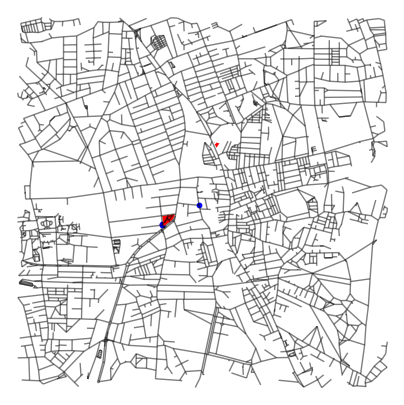

In [69]:
import matplotlib.pyplot as plt
# create a dictionary of node colors
node_ids = [1677080309,7185123220,31316277]
node_colors = {1677080309: 'blue', 7185123220: 'blue', 31316277: 'blue'}

# create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 5))

for node_id in projected_graph.nodes:
    # if the node is in the list of node IDs to highlight
    if node_id in node_ids:
        # get the node position and color
        node_pos = projected_graph.nodes[node_id]['x'], projected_graph.nodes[node_id]['y']
        node_color = node_colors[node_id]
        # plot the node with the corresponding color
        ax.scatter(*node_pos, s=10, c=node_color, edgecolors='blue')

# plot the geodataframe and the projected graph on the same axis
park_buffer.plot(ax=ax, color='red')
ox.plot_graph(projected_graph, ax=ax, node_size=0, edge_color='black', node_alpha=0.5, edge_alpha=0.5)

# show the plot
plt.show()